# Подготовка датасета для определения жанра музыки

1. Используемый датасет: GTZAN dataset.  
http://marsyasweb.appspot.com/download/data_sets/
2. Используемый алгоритм для экстракции фич: mfcc - более подробно в комментариях  
Библиотека: python_speech_features 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from copy import copy

import python_speech_features as psf
import sunau
import librosa as lb

In [4]:
OSTYPE = !uname
    
if OSTYPE == ['Linux']:
    tmp_file_names = !find ./ -type f | sort
    file_names = list()
    for file_name in tmp_file_names:
        if not (file_name.find('.wav') == -1):
            file_names.append(file_name) 
            
else:
    OSTYPE = ['Windows']
    tmp_file_names = !dir "genres" /B /S
    curr_dir = !echo %cd%
    curr_dir = curr_dir[0]+"\\" #Чтобы удалить текущую директорию

    file_names = list()
    for file_name in tmp_file_names:
        if not (file_name.find('.wav') == -1):
            file_name = file_name.replace(curr_dir, '')
            file_names.append(file_name)

In [5]:
file_name

'./Seastock_-_Cutting_Edge.wav'

In [8]:
file_name.split('/')[1]

'Seastock_-_Cutting_Edge.wav'

In [10]:
columns_audio_file = ['file_name', 'samplerate', 'duration', 'audio_data'] #Информация о файле и его содержимом в pd.DataFrame

In [12]:
audio_files = pd.DataFrame(columns=columns_audio_file)
for k, file_name in enumerate(file_names):
    audio_file = pd.Series(index=columns_audio_file)
    if OSTYPE == ['Linux']:
        audio_file.file_name = file_name.split('/')[1] 
    elif OSTYPE == ['Windows']:
        audio_file.file_name = file_name.split('\\')[0]
    
    audio_data_librosa, audio_file.samplerate = lb.load(file_name)
    audio_file.duration = len(audio_data_librosa)/audio_file.samplerate
    audio_file.audio_data = np.array(audio_data_librosa)
    audio_files = audio_files.append(audio_file, ignore_index=True)
    
audio_files

,file_name,samplerate,duration,audio_data
0,Seastock_-_Cutting_Edge.wav,22050,173,"[-5.7448e-08, 5.01812e-08, -3.85835e-08, 2.199..."


In [14]:
audio_files_backup = copy(audio_files)

In [15]:
#Восстановление из бэкапа
audio_files = copy(audio_files_backup)

In [22]:
#mfcc делает преобразования с фрагментами длительностью winlen=0.025 секунды, промежуток между началами winstep=0.01
#получаем по numcep кепстральных коэффициентов на каждый фрагмент
#mfcc = psf.mfcc(audio_file.audio_data, samplerate=audio_file.samplerate, nfft=1024)
numcep=30
winlen=0.025
winstep=0.01

#Какие статистики будут вычеслены по результату mfcc (list из tuple: название+функция)
#Еще берутся статистики разностей в туториале (я так понимаю, что между фичами?)
#http://mirlab.org/jang/books/audioSignalProcessing/appNote/musicGenreClassification/html/goTutorial.html
#http://mirlab.org/jang/books/audioSignalProcessing/appNote/musicGenreClassification/mgcFeaExtract.m
statistics_index = ['name_statistic', 'func_statistic']
statistics = [pd.Series(data=['mean', lambda x: x.mean(axis=0)], index=statistics_index),
              pd.Series(data=['std', lambda x: x.std(axis=0)], index=statistics_index),
              pd.Series(data=['max', lambda x: x.max(axis=0)], index=statistics_index),
              pd.Series(data=['min', lambda x: x.min(axis=0)], index=statistics_index),
              pd.Series(data=['diff_mean', lambda x: np.diff(x, axis=1).mean(axis=0)], index=statistics_index),
              pd.Series(data=['diff_std',  lambda x: np.diff(x, axis=1).std(axis=0)], index=statistics_index)]

for statistic in statistics:
    audio_files.loc[:, statistic.name_statistic] = None

for i in xrange(audio_files.shape[0]):
    audio_file = audio_files.loc[i]
    mfcc = psf.mfcc(audio_file.audio_data, samplerate=audio_file.samplerate, numcep=numcep,
                    winlen=winlen, winstep=winstep, nfft=1024)
    for statistic in statistics:
        audio_file[statistic.name_statistic] = statistic.func_statistic(mfcc)
    audio_files.loc[i] = audio_file
    print audio_file.name, "processed!"

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ValueError: setting an array element with a sequence.

In [ ]:
audio_files

In [24]:
#Посмотрим на профили статистик для разных жанров
#Для этого посмотрим на фильмы разных жанров с определенным номером
def StatisticsForFilmNumber(num=0):
    for statistic in statistics:
        print statistic.name_statistic
        list_names=list()
        for i in xrange(len(genres)):
            plt.plot(audio_files.loc[i*100+num][statistic.name_statistic])
            list_names.append(audio_files.loc[i*100+num]['genre'])
        plt.legend(list_names)
        plt.show()

mean


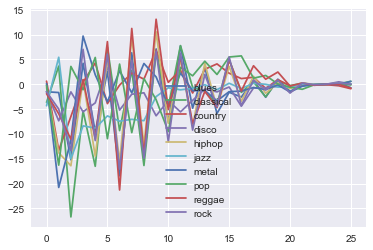

std


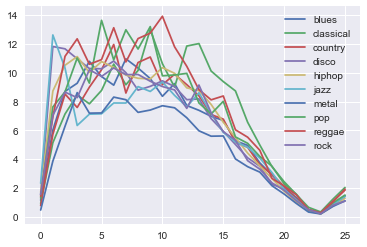

max


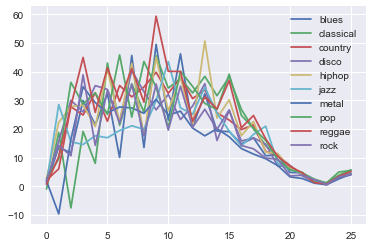

min


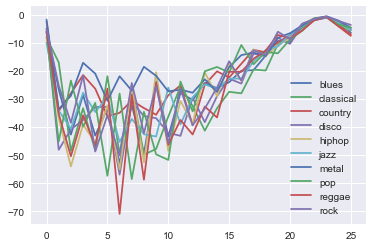

diff_mean


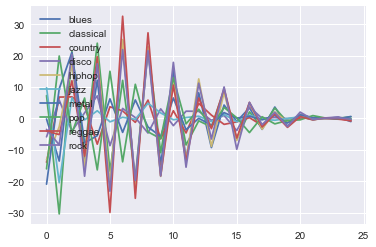

diff_std


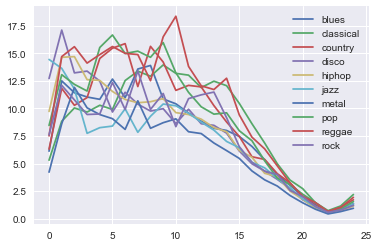

In [25]:
StatisticsForFilmNumber(0)

mean


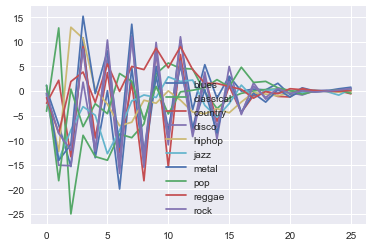

std


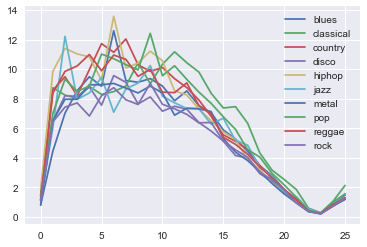

max


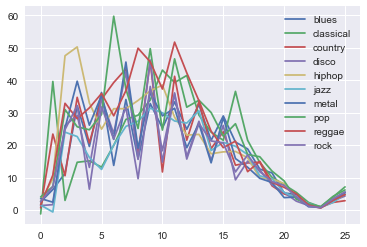

min


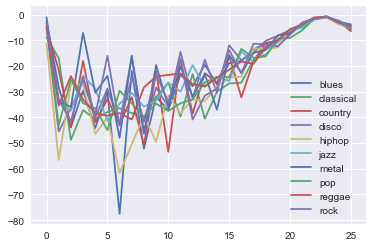

diff_mean


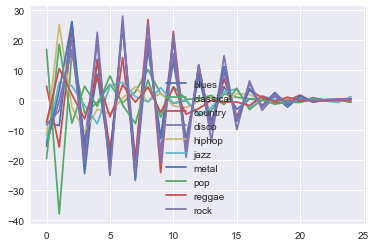

diff_std


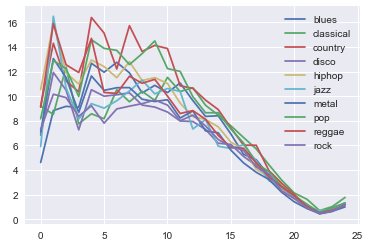

In [26]:
StatisticsForFilmNumber(73)

In [27]:
#Сохраним датасет
audio_files_save = audio_files.drop(axis=1, labels='audio_data')
audio_files_save.to_csv('dataset.csv', sep=",")

In [33]:
#Проверим загружаемость
audio_files_load = pd.read_csv('dataset.csv', index_col=0)
audio_files_load

,genre,file_name,samplerate,duration,mean,std,max,min,diff_mean,diff_std
0,blues,blues.00000.au,22050,30,[ -1.50538264 -1.66745918 -15.21220703 4.23...,[ 1.14202743 6.01268043 8.70403617 9.26...,[ 1.01400399 13.70942565 11.68709764 29.98...,[ -4.85854815 -26.57615926 -42.66757796 -28.61...,[ -1.62076547e-01 -1.35447478e+01 1.9444190...,[ 6.11997806 12.51046351 11.42995379 11.04...
1,blues,blues.00001.au,22050,30,[ -3.27341626e+00 8.52053789e-01 -2.8907873...,[ 2.1263558 8.1618835 12.70405381 12.34...,[ 1.23421579 24.11494854 25.19993601 36.74...,[ -9.67297876 -32.81133142 -51.11621653 -34.84...,[ 4.12547005 -3.74284114 7.23281575 -11.75...,[ 9.13983632 16.90063541 17.14793627 13.05...
2,blues,blues.00002.au,22050,30,[ -9.43213843e-01 3.49022076e+00 -1.8450147...,[ 1.30325969 7.3102339 9.75454936 9.58...,[ 1.94451093 30.92381031 17.56145658 42.21...,[ -7.1497022 -42.67495042 -47.42781209 -27.95...,[ 4.43343461e+00 -2.19403685e+01 1.8106328...,[ 7.93639193 12.67006977 11.11101465 14.64...
3,blues,blues.00003.au,22050,30,[ -3.39170231 9.25209884 -4.38120259 4.95...,[ 1.56811584 7.69374057 8.64939629 8.37...,[ 0.50526175 35.59888198 17.72606136 30.46...,[ -7.70663011 -21.78396563 -39.60813859 -23.36...,[ 12.64380114 -13.63330142 9.33408447 -13.09...,[ 8.32276957 12.48046539 10.38500642 11.23...
4,blues,blues.00004.au,22050,30,[ -1.96142936 0.93701381 -23.26517463 -1.32...,[ 1.88318814 9.51916117 8.22781382 9.36...,[ 2.68423869 22.249557 1.29087329 38.57...,[ -7.535371 -41.6089841 -48.90922228 -25.54...,[ 2.89844317 -24.20218844 21.94310662 -28.03...,[ 10.80234986 11.22449014 13.26978398 14.48...
5,blues,blues.00005.au,22050,30,[ -2.13538871e+00 2.49841696e+00 -1.5173896...,[ 2.25315092 14.84154267 9.90401463 13.59...,[ 3.47138862 28.17259348 19.8527738 54.43...,[ -9.04380414 -49.37085582 -38.34012376 -27.59...,[ 4.63380566e+00 -1.76723130e+01 1.9613831...,[ 16.31270029 18.18994887 15.27220357 15.75...
6,blues,blues.00006.au,22050,30,[ -2.11225679e+00 1.16528963e+01 -2.3602408...,[ 2.72318955 13.40692334 13.2523132 12.91...,[ 2.61813792 36.94733324 13.85641005 52.86...,[ -9.94682459 -38.51996341 -57.14388972 -25.54...,[ 1.37651531e+01 -3.52553045e+01 2.9949698...,[ 14.76822598 18.59751124 16.45676792 26.70...
7,blues,blues.00007.au,22050,30,[ -2.247435 7.78380454 -17.76835974 10.48...,[ 2.00717232 11.65265969 9.51996303 11.90...,[ 2.99191514 35.65089431 13.80784292 48.93...,[ -8.64027198 -43.22825191 -40.72101698 -19.46...,[ 10.03123954 -25.55216428 28.24869893 -16.54...,[ 12.66031083 14.91058721 13.48389568 18.47...
8,blues,blues.00008.au,22050,30,[ -1.55594314 -1.90990755 -11.38929456 8.59...,[ 1.09042461 6.6980525 9.92288305 11.06...,[ 0.95790908 14.38290344 9.51101863 50.40...,[ -4.98870974 -31.22306622 -47.387254 -19.01...,[ -0.35396441 -9.47938701 19.9841269 -15.15...,[ 6.94523319 15.00788849 10.85616022 15.11...
9,blues,blues.00009.au,22050,30,[ -3.07371572e+00 -3.31702137e-01 -1.2556826...,[ 2.346827 7.72442004 11.50908304 11.84...,[ 2.44348114 20.08284787 12.96071091 58.16...,[ -7.20556381 -46.29555427 -43.11173933 -20.41...,[ 2.74201358 -12.2251245 19.50174608 -32.45...,[ 8.17247535 15.69222587 16.59228327 17.83...


** Прикинем предсказания **   
Проверим, что графики будут хоть как-то различаться

In [29]:
audio_files[audio_files.genre == 'rock']['mean'].values[0]

array([ -1.51443284,  -4.99710807, -13.37855108,   7.03565673,
       -11.33545283,   6.06707676, -17.08704379,   4.83689235,
       -14.8826728 ,   6.70624889, -11.5870631 ,   6.26924333,
        -9.22841086,   2.0012199 ,  -4.5342937 ,   5.49006709,
        -4.30771584,   0.82821495,  -1.14514017,   0.80867986,
        -1.7755917 ,   0.25141477,  -0.09910513,   0.04967342,
         0.23250639,   0.03216289])

mean


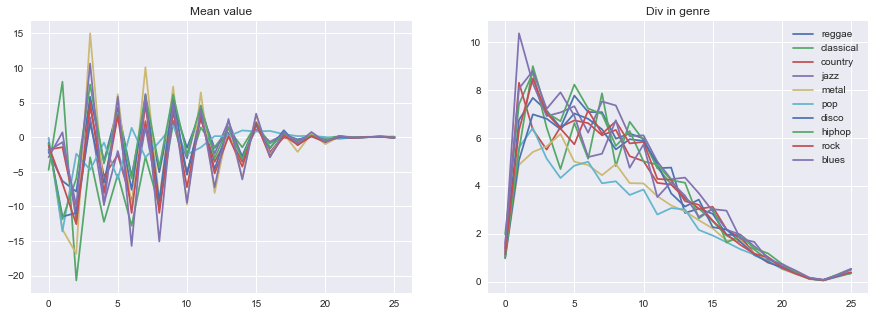

std


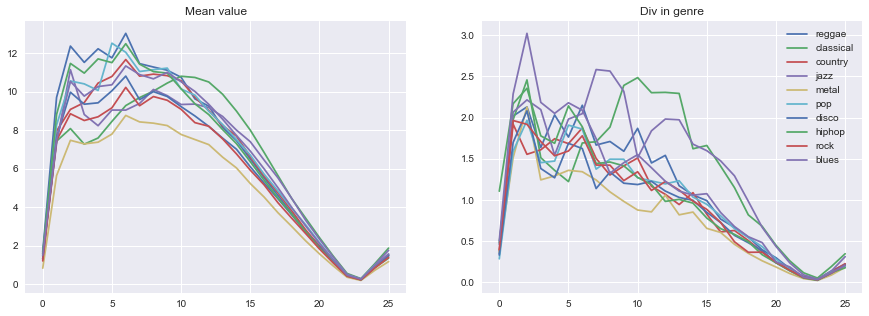

max


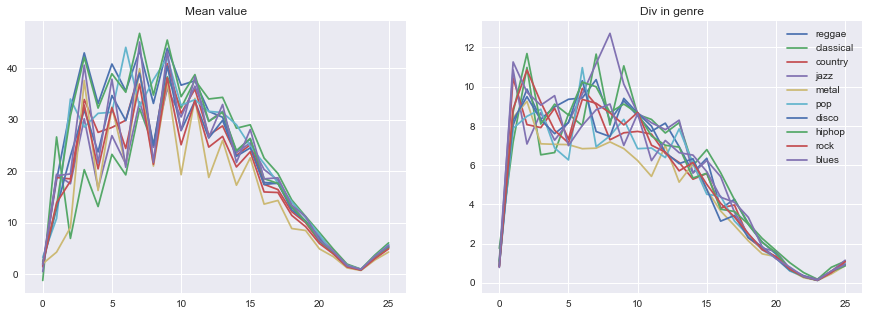

min


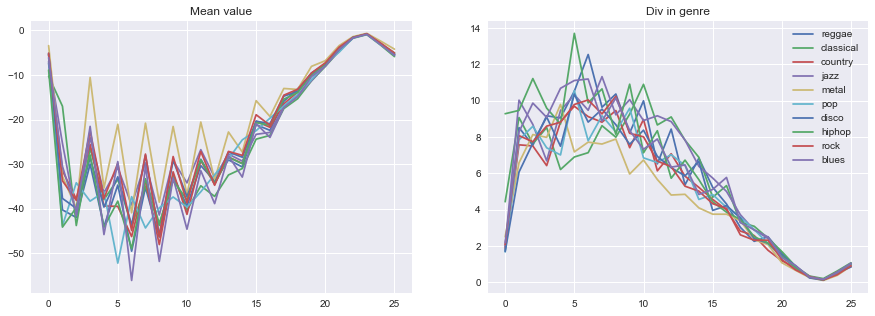

diff_mean


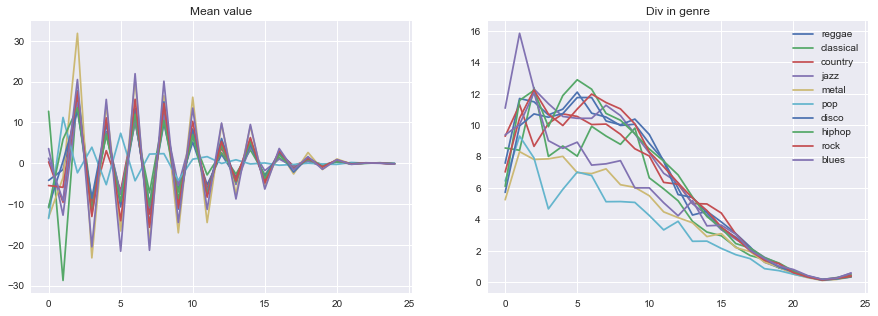

diff_std


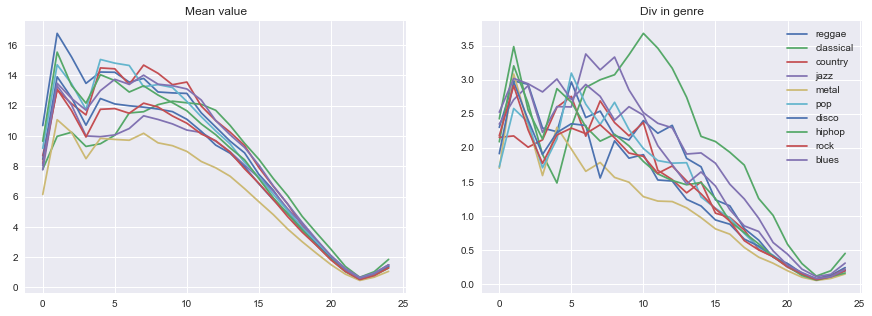

In [30]:
#Усредним каждую статистику по жанрам
for statistic in statistics:
    figure, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].set_title('Mean value')
    axes[1].set_title('Div in genre')
    for genre in genres:
        arr = np.vstack(audio_files[audio_files.genre == genre][statistic.name_statistic].values)
        axes[0].plot(arr.mean(axis=0))
        axes[1].plot(arr.std(axis=0))
        
    print statistic.name_statistic
    plt.legend(genres)
    plt.show()